In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pydot
import visualkeras
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
from PIL import ImageFont
from collections import defaultdict

import os
os.chdir('F:\Другое\PythonFiles\Facial-emotion-recognition-master')

print(os.getcwd())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

f:\Другое\PythonFiles\Facial-emotion-recognition-master
1 Physical GPUs, 1 Logical GPUs


In [2]:
def preprocess_data():
    data = pd.read_csv('fer2013.csv')
    labels = pd.read_csv('fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y

In [3]:
def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

   
    y = y[:, :-2] * 0.1

   
    y[:, 0] += y[:, 7]
    y = y[:, :7]

   
    X = X / 255.0

    return X, y

In [4]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

   
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test


In [5]:
def data_good(x_train):
    datagood = ImageDataGenerator()
    datagood.fit(x_train)
    return datagood


In [6]:
def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen


In [7]:
def show_images(datagood, x_train, y_train):
    it = datagood.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        #plt.xlabel(class_names[y_train[i]])
    plt.show()

In [8]:
def show_augmented_images(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        #plt.xlabel(class_names[y_train[i]])
    plt.show()

In [9]:
def define_model(input_shape=(48, 48, 1), classes=7):
   

    model = tf.keras.models.Sequential()

   
    model.add(Conv2D(32, kernel_size=(1, 1), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.25))

   
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

   
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.2))

  
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

   
    model.add(Conv2D(256, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))


    model.add(Flatten())

  
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(classes, activation='softmax'))

    return model

In [10]:
def plot_acc_loss(history):
   
    plt.plot(history.history['accuracy'], label='Тренировочный набор')
    plt.plot(history.history['val_accuracy'], label='Валидационный набор')
    plt.xlabel('Количество эпох')
    plt.ylabel('Точность')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    
    plt.plot(history.history['loss'], label='Отклонение тр. набора')
    plt.plot(history.history['val_loss'], label='Отклонение влд. набора')
    plt.xlabel('Количество эпох')
    plt.ylabel('Отклонение')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()

In [11]:
def save_model_and_weights(model, test_acc):
    
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('models\\model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
  
    model.save_weights('models\\model' + str(test_acc) + '.h5')
    color_map = defaultdict(dict)
    color_map[Flatten]['fill'] = 'black'
    color_map[Dense]['fill'] = 'green'
    font = ImageFont.truetype("arial.ttf", 28)
    visualkeras.layered_view(model, legend=True, font=font, to_file='output.png')
    print('Модель и весы сохранены.')

In [12]:
def load_model_and_weights(model_path, weights_path):
   
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

   
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Модель и весы загружены.')

In [13]:
def run_model():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    X, y = preprocess_data()
    X, y = clean_data_and_normalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
    datagen = data_augmentation(x_train)

    epochs = 100
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))


   
    model = define_model(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()

    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

  
    visualkeras.layered_view(model, legend=True)
    visualkeras.layered_view(model, legend=True, to_file='output.png')

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val), verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

    plot_acc_loss(history)
    save_model_and_weights(model, test_acc)

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        64        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        1056      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)  

C:\Users\nikit\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
443/443 - 40s - loss: 0.3533 - accuracy: 0.3732 - val_loss: 0.3800 - val_accuracy: 0.3798 - 40s/epoch - 91ms/step
Epoch 2/100
443/443 - 31s - loss: 0.3267 - accuracy: 0.4772 - val_loss: 0.3121 - val_accuracy: 0.5469 - 31s/epoch - 69ms/step
Epoch 3/100
443/443 - 31s - loss: 0.3078 - accuracy: 0.5371 - val_loss: 0.2972 - val_accuracy: 0.5813 - 31s/epoch - 69ms/step
Epoch 4/100
443/443 - 31s - loss: 0.2935 - accuracy: 0.5727 - val_loss: 0.2933 - val_accuracy: 0.5993 - 31s/epoch - 69ms/step
Epoch 5/100
443/443 - 31s - loss: 0.2799 - accuracy: 0.6075 - val_loss: 0.2700 - val_accuracy: 0.6354 - 31s/epoch - 70ms/step
Epoch 6/100
443/443 - 31s - loss: 0.2675 - accuracy: 0.6331 - val_loss: 0.2741 - val_accuracy: 0.6678 - 31s/epoch - 69ms/step
Epoch 7/100
443/443 - 31s - loss: 0.2582 - accuracy: 0.6551 - val_loss: 0.2524 - val_accuracy: 0.6926 - 31s/epoch - 69ms/step
Epoch 8/100
443/443 - 31s - loss: 0.2506 - accuracy: 0.6751 - val_loss: 0.2440 - val_accuracy: 0.6926 - 31s/epoch - 69

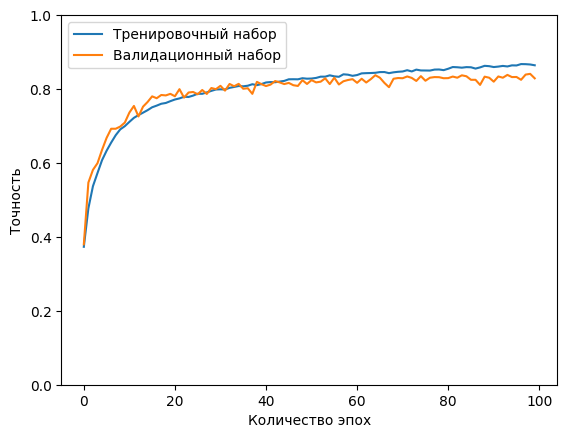

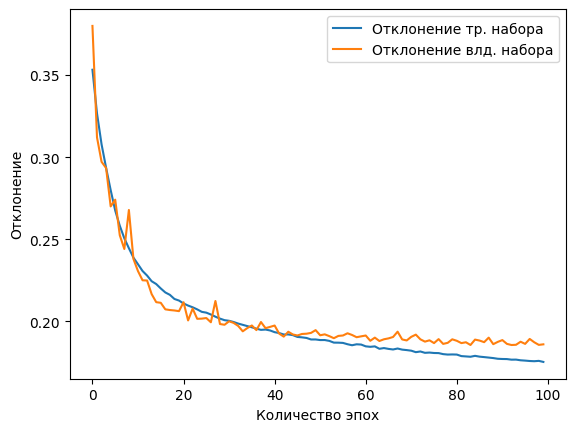

Модель и весы сохранены.


In [14]:
run_model()

In [15]:
'''def test():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

    X, y = preprocess_data()
    X, y = clean_data_and_normalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
    datagood = data_good(x_train)
    show_images(datagood, x_train, y_train)
    datagen = data_augmentation(x_train)
    show_augmented_images(datagen, x_train, y_train)

    epochs = 2
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))'''

'def test():\n    fer_classes = [\'neutral\', \'happiness\', \'surprise\', \'sadness\', \'anger\', \'disgust\', \'fear\', \'contempt\']\n\n    X, y = preprocess_data()\n    X, y = clean_data_and_normalize(X, y)\n    x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)\n    datagood = data_good(x_train)\n    show_images(datagood, x_train, y_train)\n    datagen = data_augmentation(x_train)\n    show_augmented_images(datagen, x_train, y_train)\n\n    epochs = 2\n    batch_size = 64\n\n    print("X_train shape: " + str(x_train.shape))\n    print("Y_train shape: " + str(y_train.shape))\n    print("X_test shape: " + str(x_test.shape))\n    print("Y_test shape: " + str(y_test.shape))\n    print("X_val shape: " + str(x_val.shape))\n    print("Y_val shape: " + str(y_val.shape))'

In [16]:
#test()